In [8]:
# Jupyer Notebook Theme: jt -t monokai -f fira -fs 10 -nf ptsans -nfs 11 -N -kl -cursw 2 -cursc r -cellw 95% -T
# Check python version
import sys
cdPyVer = 0x600
cdSysVer = sys.version[:5]
print("%s%s" %("My python version is: ", cdSysVer)) # strangely it works only on 3.7.4 and not 3.7.6
from tqdm.auto import tqdm
# Import libraries
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.gridspec import GridSpec
plt.style.use('seaborn-dark') # use this theme as you are using dark theme in the notebook
import seaborn as sns
import folium
from folium.plugins import HeatMap, FastMarkerCluster

# Utils modules
sys.path.append('/Users/Shandeep/qc_data_insights/personal/shandeep/scripts/')
from custom_transformers import *
from viz_utils import *


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

My python version is: 3.9.7


In [9]:
"""
Connect to big query and then run analysis acordingly.
"""

#import sys
sys.path.append('/Users/Shandeep/qc_data_insights/utils/') # git clone this repository qc_data_insights
import utils as u 
import os
from google.oauth2 import service_account
# pip install google-cloud-bigquery==1.24.0 # requires this version.. current version is bugged with pandas
from google.cloud import bigquery

google_credentials_path = os.path.expanduser('~')+'/Documents/google_cloud_data-insights-team.json' # make sure add json file credentials in documents folder
credentials = service_account.Credentials.from_service_account_file(google_credentials_path)
bqclient = bigquery.Client(credentials=credentials, project=credentials.project_id)
print(f'connected to BigQuery, project: {bqclient.project} on version {bigquery.__version__}')

connected to BigQuery, project: dh-darkstores-live on version 1.24.0


In [61]:
# Filters in query 
global_entity_id = input()

query =f""" 
SELECT global_entity_id
,   DATE(order_placed_localtime_at) AS order_date
,   order_id
,   analytical_customer_id AS customer_id
,   items.sku
,   items.product.product_name AS product
,   items.qty_sold
,   items.value_euro.unit_price_paid_eur AS unit_price
FROM `fulfillment-dwh-production.cl_dmart.customer_orders`, UNNEST(items) AS items
WHERE DATE(order_placed_localtime_at) < CURRENT_DATE()
AND global_entity_id = '{global_entity_id}'
AND is_dmart 
AND is_failed = FALSE 
AND is_cancelled = FALSE
AND analytical_customer_id IS NOT NULL 
AND order_id IS NOT NULL
AND DATE_TRUNC(order_placed_localtime_at, MONTH) > DATE_SUB(CURRENT_DATE(), INTERVAL 5 MONTH)
AND DATE_TRUNC(order_placed_localtime_at, MONTH) <= CURRENT_DATE()
"""
# Read query and display in the form of a pandas dataframe
df = u.read_bigquery(query, bqclient, parse_dates=[], verbose=True)
df.head()


FP_SG
running query... job done, downloading... 

Downloading:   0%|          | 0/8134367 [00:00<?, ?rows/s]

done with shape (8134367, 8)


,global_entity_id,order_date,order_id,customer_id,sku,product,qty_sold,unit_price
0,FP_SG,2021-10-11,n7no-gwl0,KN3djPbuWXSQ2CEl3AnI9A,NJ34MM,Monster Mango Loco 355ml,5.000000000,1.626012
1,FP_SG,2021-10-11,n7no-dew6,njNyhLziW0y--GMJ3SXF-Q,96G0SP,Monster Energy Ultra 355ml,8.000000000,1.626012
2,FP_SG,2021-10-11,n7no-42xr,Wx47hpMUUt6Hupibklx04g,3D8JR9,Elkali Natural Alkaline Spring Water Bottle 1.25L,8.000000000,1.625193
3,FP_SG,2021-10-11,n7no-0vl5,SWcIKrwLUTahEI6PkZoAfw,3V3O0L,SD Biosensor COVID-19 ART Self-test Kit - 5 Test,5.000000000,31.244939
4,FP_SG,2021-10-11,n7no-0x06,cAzKd0ySWvyiKGp2oG1pEw,11048J,Yakult Cultured Milk Drink (Grape) 5s x 100ml,5.000000000,2.040486


In [62]:
u.df_mem_usage(df)

'496.48 MB'

In [63]:
df.shape

(8134367, 8)

In [65]:
online = df.copy()

### Assign Acquisition Month to each Customer

In [66]:
import datetime as dt
def get_month(x): return dt.datetime(x.year, x.month, 1)
online['order_month'] = online['order_date'].apply(get_month)
grouping = online.groupby('customer_id')['order_month'] 
online['cohort_month'] = grouping.transform('min') # Minimum value for order_month for each customer
online.head()

,global_entity_id,order_date,order_id,customer_id,sku,product,qty_sold,unit_price,order_month,cohort_month
0,FP_SG,2021-10-11,n7no-gwl0,KN3djPbuWXSQ2CEl3AnI9A,NJ34MM,Monster Mango Loco 355ml,5.000000000,1.626012,2021-10-01,2021-10-01
1,FP_SG,2021-10-11,n7no-dew6,njNyhLziW0y--GMJ3SXF-Q,96G0SP,Monster Energy Ultra 355ml,8.000000000,1.626012,2021-10-01,2021-06-01
2,FP_SG,2021-10-11,n7no-42xr,Wx47hpMUUt6Hupibklx04g,3D8JR9,Elkali Natural Alkaline Spring Water Bottle 1.25L,8.000000000,1.625193,2021-10-01,2021-09-01
3,FP_SG,2021-10-11,n7no-0vl5,SWcIKrwLUTahEI6PkZoAfw,3V3O0L,SD Biosensor COVID-19 ART Self-test Kit - 5 Test,5.000000000,31.244939,2021-10-01,2021-06-01
4,FP_SG,2021-10-11,n7no-0x06,cAzKd0ySWvyiKGp2oG1pEw,11048J,Yakult Cultured Milk Drink (Grape) 5s x 100ml,5.000000000,2.040486,2021-10-01,2021-06-01


In [19]:
def get_date_int(df, column):
    """
    Define function to extract year, month and day integer values
    """
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [68]:
# Assign time offset value
order_year, order_month, _ = get_date_int(online, 'order_month')
cohort_year, cohort_month, _ = get_date_int(online, 'cohort_month')
years_diff = order_year - cohort_year
months_diff = order_month - cohort_month
online['cohort_index'] = years_diff * 12 + months_diff + 1
online.head()

,global_entity_id,order_date,order_id,customer_id,sku,product,qty_sold,unit_price,order_month,cohort_month,cohort_index
0,FP_SG,2021-10-11,n7no-gwl0,KN3djPbuWXSQ2CEl3AnI9A,NJ34MM,Monster Mango Loco 355ml,5.000000000,1.626012,2021-10-01,2021-10-01,1
1,FP_SG,2021-10-11,n7no-dew6,njNyhLziW0y--GMJ3SXF-Q,96G0SP,Monster Energy Ultra 355ml,8.000000000,1.626012,2021-10-01,2021-06-01,5
2,FP_SG,2021-10-11,n7no-42xr,Wx47hpMUUt6Hupibklx04g,3D8JR9,Elkali Natural Alkaline Spring Water Bottle 1.25L,8.000000000,1.625193,2021-10-01,2021-09-01,2
3,FP_SG,2021-10-11,n7no-0vl5,SWcIKrwLUTahEI6PkZoAfw,3V3O0L,SD Biosensor COVID-19 ART Self-test Kit - 5 Test,5.000000000,31.244939,2021-10-01,2021-06-01,5
4,FP_SG,2021-10-11,n7no-0x06,cAzKd0ySWvyiKGp2oG1pEw,11048J,Yakult Cultured Milk Drink (Grape) 5s x 100ml,5.000000000,2.040486,2021-10-01,2021-06-01,5


### Count monthly active customers from each cohort

In [70]:
grouping = online.groupby(['cohort_month','cohort_index']) # create group by object
cohort_data = grouping['customer_id'].apply(pd.Series.nunique) # Count number of customers in each group
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index = 'cohort_month', columns = 'cohort_index', values = 'customer_id')
display(cohort_counts)

cohort_index,1,2,3,4,5
cohort_month,,,,,
2021-06-01,143243.0,80912.0,76099.0,71607.0,57088.0
2021-07-01,68341.0,21197.0,19386.0,13749.0,NaN
2021-08-01,41575.0,11462.0,7679.0,NaN,NaN
2021-09-01,36326.0,7247.0,NaN,NaN,NaN
2021-10-01,20161.0,NaN,NaN,NaN,NaN


### Calculate Retention Rate of our customers over time!

In [71]:
# Store the firt column as cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]
# Divide all values in the cohort counts table by cohort sizes, axis = 0 (to ensure we are dividing along row axis)
retention = cohort_counts.divide(cohort_sizes, axis = 0)
# Review retention table
retention.round(3) * 100

cohort_index,1,2,3,4,5
cohort_month,,,,,
2021-06-01,100.0,56.5,53.1,50.0,39.9
2021-07-01,100.0,31.0,28.4,20.1,NaN
2021-08-01,100.0,27.6,18.5,NaN,NaN
2021-09-01,100.0,19.9,NaN,NaN,NaN
2021-10-01,100.0,NaN,NaN,NaN,NaN


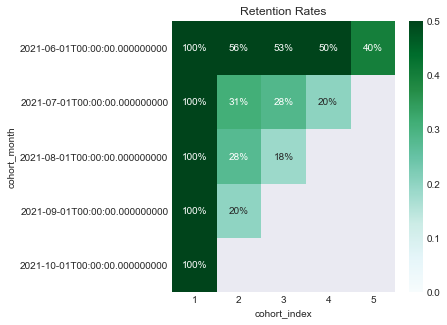

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize= (5,5))
plt.title('Retention Rates')
sns.heatmap(data = retention, annot = True, fmt = '.0%', vmin = 0.0, vmax = 0.5, cmap = 'BuGn')
plt.show()

In [74]:
online.head()

,global_entity_id,order_date,order_id,customer_id,sku,product,qty_sold,unit_price,order_month,cohort_month,cohort_index
0,FP_SG,2021-10-11,n7no-gwl0,KN3djPbuWXSQ2CEl3AnI9A,NJ34MM,Monster Mango Loco 355ml,5.000000000,1.626012,2021-10-01,2021-10-01,1
1,FP_SG,2021-10-11,n7no-dew6,njNyhLziW0y--GMJ3SXF-Q,96G0SP,Monster Energy Ultra 355ml,8.000000000,1.626012,2021-10-01,2021-06-01,5
2,FP_SG,2021-10-11,n7no-42xr,Wx47hpMUUt6Hupibklx04g,3D8JR9,Elkali Natural Alkaline Spring Water Bottle 1.25L,8.000000000,1.625193,2021-10-01,2021-09-01,2
3,FP_SG,2021-10-11,n7no-0vl5,SWcIKrwLUTahEI6PkZoAfw,3V3O0L,SD Biosensor COVID-19 ART Self-test Kit - 5 Test,5.000000000,31.244939,2021-10-01,2021-06-01,5
4,FP_SG,2021-10-11,n7no-0x06,cAzKd0ySWvyiKGp2oG1pEw,11048J,Yakult Cultured Milk Drink (Grape) 5s x 100ml,5.000000000,2.040486,2021-10-01,2021-06-01,5


### RFM

In [76]:
online['qty_sold'] = online['qty_sold'].astype(int)

dmart = online.copy()
# Create new column called total_sum
dmart['total_sum'] = dmart['qty_sold'] * dmart['unit_price']
dmart.head()

,global_entity_id,order_date,order_id,customer_id,sku,product,qty_sold,unit_price,order_month,cohort_month,cohort_index,total_sum
0,FP_SG,2021-10-11,n7no-gwl0,KN3djPbuWXSQ2CEl3AnI9A,NJ34MM,Monster Mango Loco 355ml,5,1.626012,2021-10-01,2021-10-01,1,8.130061
1,FP_SG,2021-10-11,n7no-dew6,njNyhLziW0y--GMJ3SXF-Q,96G0SP,Monster Energy Ultra 355ml,8,1.626012,2021-10-01,2021-06-01,5,13.008097
2,FP_SG,2021-10-11,n7no-42xr,Wx47hpMUUt6Hupibklx04g,3D8JR9,Elkali Natural Alkaline Spring Water Bottle 1.25L,8,1.625193,2021-10-01,2021-09-01,2,13.001547
3,FP_SG,2021-10-11,n7no-0vl5,SWcIKrwLUTahEI6PkZoAfw,3V3O0L,SD Biosensor COVID-19 ART Self-test Kit - 5 Test,5,31.244939,2021-10-01,2021-06-01,5,156.224693
4,FP_SG,2021-10-11,n7no-0x06,cAzKd0ySWvyiKGp2oG1pEw,11048J,Yakult Cultured Milk Drink (Grape) 5s x 100ml,5,2.040486,2021-10-01,2021-06-01,5,10.202429


In [78]:
snapshot_date = max(dmart.order_date) + datetime.timedelta(days = 1)

In [79]:
"""
Calculate RFM Metrics
"""
# Aggregate data on a customer level
dmart = dmart.groupby(['customer_id']).agg({
    'order_date': lambda x: (snapshot_date - x.max()).days, # difference between snapshot data and most recent invoice date
    'order_id': 'count',
    'total_sum': 'sum'})

dmart.rename(columns = {'order_date':'Recency',
                        'order_id':'Frequency',
                        'total_sum': 'MonetaryValue'}, inplace = True)
dmart.head()

,Recency,Frequency,MonetaryValue
customer_id,,,
---IZJY0UnGjkanUMcK_Jw,15,9,35.338830
---tf2KCUXSV4UJvpPxOXw,123,35,94.007067
--0yhaDNUsitDOlP7CzfCg,106,12,15.916533
--1MhNFHU6yC4mrDd483_g,131,2,3.723221
--1y95TuWmCHdn0aI1Ni2Q,89,48,134.703111


Input indexes for RFM

In [83]:
r_labels = range(4,0,-1) # Reverse Labelling
r_quartiles = pd.qcut(dmart['Recency'],4,labels = r_labels)
dmart = dmart.assign(R = r_quartiles.values)

In [85]:
f_labels = range(1,5)
m_labels = range(1,5)
f_quartiles = pd.qcut(dmart['Frequency'],4,labels = f_labels)
m_quartiles = pd.qcut(dmart['MonetaryValue'],4,labels = m_labels)
dmart = dmart.assign(F = f_quartiles.values)
dmart = dmart.assign(M = m_quartiles.values)

In [86]:
dmart.head()

,Recency,Frequency,MonetaryValue,R,F,M
customer_id,,,,,,
---IZJY0UnGjkanUMcK_Jw,15,9,35.338830,3,2,2
---tf2KCUXSV4UJvpPxOXw,123,35,94.007067,1,4,3
--0yhaDNUsitDOlP7CzfCg,106,12,15.916533,1,3,1
--1MhNFHU6yC4mrDd483_g,131,2,3.723221,1,1,1
--1y95TuWmCHdn0aI1Ni2Q,89,48,134.703111,1,4,4


**Build RFM Segment and RFM score**

In [87]:
"""
- Concatenate RFM quartile values to RFM_Segment
- Sum RFM quartiles to RFM_Score
"""
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
dmart['RFM_Segment'] = dmart.apply(join_rfm, axis = 1)
dmart['RFM_Score'] = dmart[['R','F','M']].sum(axis=1)

In [88]:
dmart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
customer_id,,,,,,,,
---IZJY0UnGjkanUMcK_Jw,15,9,35.338830,3,2,2,3.02.02.0,7
---tf2KCUXSV4UJvpPxOXw,123,35,94.007067,1,4,3,1.04.03.0,8
--0yhaDNUsitDOlP7CzfCg,106,12,15.916533,1,3,1,1.03.01.0,5
--1MhNFHU6yC4mrDd483_g,131,2,3.723221,1,1,1,1.01.01.0,3
--1y95TuWmCHdn0aI1Ni2Q,89,48,134.703111,1,4,4,1.04.04.0,9


In [89]:
dmart.groupby('RFM_Segment').size().sort_values(ascending = False)[:10] # Lowest and highest rated RFM segments are amongst the highest

RFM_Segment
4.04.04.0    39732
1.01.01.0    25067
3.04.04.0    16665
3.03.03.0    14060
1.02.01.0    13423
2.01.01.0    13399
2.03.03.0    12521
1.02.02.0    11567
2.02.02.0    11149
4.03.03.0    10593
dtype: int64

In [96]:
"""
Summary Metrics per RFM Score:
"""
dmart.groupby('RFM_Score').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean','count']
}).round(1)

Recency Frequency MonetaryValue       
             mean      mean          mean  count
RFM_Score                                       
3           110.9       2.5          10.4  25067
4            90.0       3.9          14.7  35483
5            70.8       4.9          21.0  35846
6            53.9       6.6          27.5  34174
7            47.0       9.7          38.8  31421
8            38.0      13.7          54.3  29879
9            26.9      19.3          75.8  27016
10           20.5      29.1         114.7  25381
11           14.8      53.1         201.5  25647
12            4.8     105.5         384.8  39732

In [98]:
"""
Use RFM Score to group customers into Gold, Silver and Bronze segments
"""
def segment_me(df):
    if df['RFM_Score'] >= 9:
        return 'Gold'
    elif (df['RFM_Score'] >=5) and (df['RFM_Score'] < 9):
        return 'Silver'
    else:
        return 'Bronze'
    
dmart['General_Segment'] = dmart.apply(segment_me, axis = 1)
dmart.groupby('General_Segment').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean','count']
}).round(1)

Recency Frequency MonetaryValue        
                   mean      mean          mean   count
General_Segment                                        
Bronze             98.7       3.3          12.9   60550
Gold               15.4      57.9         215.8  117776
Silver             53.3       8.5          34.5  131320